In [11]:
import gym
import numpy as np
import pandas as pd
import plotly.express as px
from time import sleep
import ipywidgets as widgets

In [41]:
class Data():
    def __init__(self):
        self.states = []
    
    def add(self,state):
        self.states.append(state)
        
    def graph(self):
        states = np.array(self.states).reshape(len(self.states),-1)
        f = pd.DataFrame({ 'x' : states[:,0],
                           'y' : states[:,1],
                           'vx' : states[:,2],
                           'vy' : states[:,3],
                           'theta' : states[:,4],
                           'vtheta' : states[:,5]})
                      
        fig = px.line(f)
        fig.show()
    
def pid(state, params):
    # PID parameters
    kp_alt = params[0]  
    kd_alt = params[1]  
    kp_ang = params[2]  
    kd_ang = params[3] 
    
    # Calculate setpoints (target values)
    alt_tgt = np.abs(state[0])
    ang_tgt = (.25*np.pi)*(state[0]+state[2])

    # Calculate error values
    alt_error = (alt_tgt - state[1])
    ang_error = (ang_tgt - state[4])
    
    # Use PID to get adjustments
    alt_adj = kp_alt*alt_error + kd_alt*state[3]
    ang_adj = kp_ang*ang_error + kd_ang*state[5]
        
    a = np.array([alt_adj, ang_adj])
    a = np.clip(a, -1, +1)
 
    # If the legs are on the ground we made it, kill engines
    if(state[6] or state[7]):
        a[:] = 0   
    return a

def run(params, env, verbose=False):
    """ runs an episode given pid parameters """
    data = Data() 
    done = False
    state = env.reset()
    if verbose:
        env.render()
        sleep(.005)
    data.add(state)
    total = 0
    while not done:
        a = pid(state,params)
        state,reward,done,_ = env.step(a)
        total += reward
        if verbose:
            env.render()
            sleep(.005)
        data.add(state)
    return total, data

def optimize(params, current_score, env, step):
    """ runs a step of randomized hill climbing """

    # add gaussian noise (less noise as n_steps increases)
    test_params = params + np.random.normal(0,20.0/step,size=params.shape)
    
    # test params over 5 trial avg
    scores = []
    for trial in range(5):
        score,_ = run(test_params,env)
        scores.append(score)
    avg = np.mean(scores)
    
    # update params if improved
    if avg > current_score:
        return test_params,avg
    else:
        return params,current_score

In [43]:
def simulate(button):
    env = gym.make('LunarLanderContinuous-v2')
    env.seed()

    params = np.array([widget_params[0].value,widget_params[1].value,widget_params[2].value,widget_params[3].value])
    score, data = run(params, env, True)
    env.close()
    print ("Score:",score)
    if checkbox.value:
        data.graph()
    
widget_params = [widgets.FloatSlider(
    value=7,
    min=-20,
    max=20,
    step=0.1,
    description=name,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)for name in ['Kp','Kd','Kp','Kd']]
button = widgets.Button(
    description='Start',
    disabled=False,
    button_style='',
    tooltip='Click me',
    icon='check'
)
checkbox = widgets.Checkbox(
    value=False,
    description='Debug',
    disabled=False,
    indent=False
)
button.on_click(simulate)
center_layout = widgets.Layout(display='flex',flex_flow='column',align_items='center')
alt_box = widgets.VBox([widgets.Label("Altitude",layout = center_layout), widget_params[0], widget_params[1]])
ang_box = widgets.VBox([widgets.Label("Anagle",layout = center_layout), widget_params[2], widget_params[3]])
cnt_box = widgets.VBox([widgets.Label("Simulation"),button,checkbox])
widgets.HBox([alt_box, ang_box,cnt_box])

### Kalkuliranje na najdobrite parametri

Step: 0 Score: -55.909280383677675 Params: [12.9243555  -2.63141823 -3.5073271  24.43166283]
Step: 10 Score: 221.25218074729491 Params: [ 23.18932954 -20.35372943 -20.43138447  14.96945662]
Step: 20 Score: 266.91152517105763 Params: [ 19.94748209 -18.61309476 -18.34578529  15.2226399 ]
Step: 30 Score: 266.91152517105763 Params: [ 19.94748209 -18.61309476 -18.34578529  15.2226399 ]
Step: 40 Score: 266.91152517105763 Params: [ 19.94748209 -18.61309476 -18.34578529  15.2226399 ]
Step: 50 Score: 266.91152517105763 Params: [ 19.94748209 -18.61309476 -18.34578529  15.2226399 ]
Step: 60 Score: 266.91152517105763 Params: [ 19.94748209 -18.61309476 -18.34578529  15.2226399 ]
Step: 70 Score: 266.91152517105763 Params: [ 19.94748209 -18.61309476 -18.34578529  15.2226399 ]
Step: 80 Score: 266.91152517105763 Params: [ 19.94748209 -18.61309476 -18.34578529  15.2226399 ]
Step: 90 Score: 266.91152517105763 Params: [ 19.94748209 -18.61309476 -18.34578529  15.2226399 ]
Step: 100 Score: 266.9115251710576

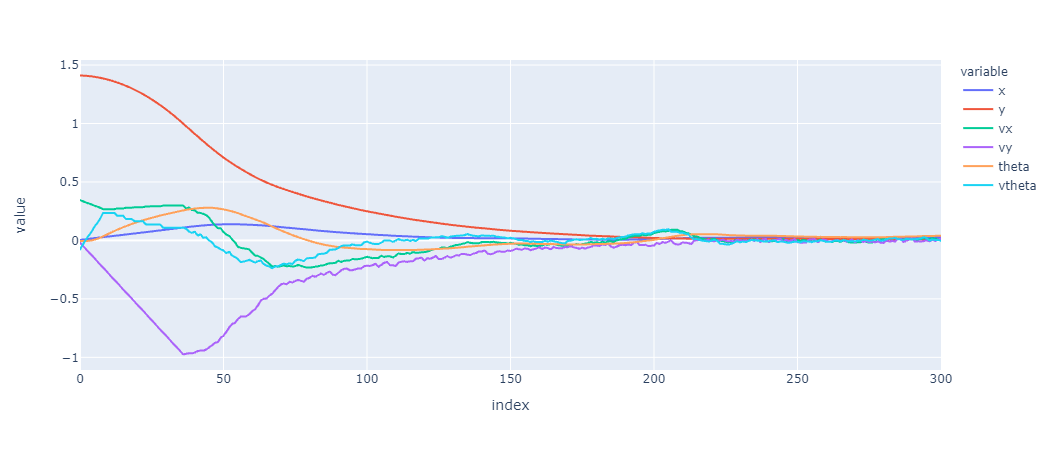

In [44]:
env = gym.make('LunarLanderContinuous-v2')
env._max_episode_steps = 300

params = np.array([0,0,0,0])
score = -300 
for steps in range(101):
    params,score = optimize(params,score,env,steps+1)
    if steps%10 == 0:
        print( "Step:",steps,"Score:",score,"Params:",params)

# Get data for final run
scores = []
for trial in range(10):
    score, data = run(params, env, True)
    scores.append(score)
env.close()
print ("Average Score:",np.mean(scores))
data.graph()

### Koristejki evristika od lib

In [49]:
def heuristic(env, s):

    angle_targ = s[0]*0.5 + s[2]*1.0         # angle should point towards center
    if angle_targ > 0.4: angle_targ = 0.4    # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4: angle_targ = -0.4
    hover_targ = 0.55*np.abs(s[0])           # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5])*1.0
    hover_todo = (hover_targ - s[1])*0.5 - (s[3])*0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = -(s[3])*0.5  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo*20 - 1, -angle_todo*20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05: a = 2
        elif angle_todo < -0.05: a = 3
        elif angle_todo > +0.05: a = 1
    return a

def demo_heuristic_lander(env, seed=None, render=False):
    env.seed(seed)
    total_reward = 0
    steps = 0
   
    s = env.reset()
    while True:
        a = heuristic(env, s)
        s, r, done, info = env.step(a)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open == False: break
    
        if steps % 20 == 0 or done:
            print("observations:", " ".join(["{:+0.2f}".format(x) for x in s]))
            print("step {} total_reward {:+0.2f}".format(steps, total_reward))
        steps += 1
        if done: break
    env.close()
    return total_reward

demo_heuristic_lander(env,render=True)

observations: +0.00 +1.39 +0.09 -0.48 +0.00 +0.03 +0.00 +0.00
step 0 total_reward -1.08
observations: +0.02 +1.05 +0.09 -1.02 +0.03 +0.03 +0.00 +0.00
step 20 total_reward -22.33
observations: +0.04 +0.61 +0.12 -0.82 +0.07 +0.04 +0.00 +0.00
step 40 total_reward +30.92
observations: +0.06 +0.32 +0.12 -0.46 +0.11 +0.03 +0.00 +0.00
step 60 total_reward +85.15
observations: +0.07 +0.16 -0.01 -0.27 +0.10 -0.04 +0.00 +0.00
step 80 total_reward +116.42
observations: +0.06 +0.07 -0.12 -0.18 +0.06 -0.07 +0.00 +0.00
step 100 total_reward +130.95
observations: +0.03 +0.01 -0.15 -0.14 +0.00 -0.07 +0.00 +0.00
step 120 total_reward +139.94
observations: +0.01 -0.00 -0.03 +0.00 -0.00 -0.00 +1.00 +1.00
step 140 total_reward +178.29
observations: +0.01 -0.00 +0.00 +0.00 -0.00 -0.00 +1.00 +1.00
step 160 total_reward +181.58
observations: +0.01 -0.00 +0.00 +0.00 -0.00 +0.00 +1.00 +1.00
step 170 total_reward +281.58


281.5811364432957